In [172]:
import sys
import os
from os import path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("/home/fm02/MEG_NEOS/NEOS")
import NEOS_config as config

#os.chdir("/home/fm02/MEG_NEOS/NEOS/my_eyeCA")
from my_eyeCA import preprocess, ica, snr_metrics

os.chdir("/home/fm02/MEG_NEOS/NEOS")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#mne.viz.set_browser_backend("matplotlib")

In [173]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib as mpl
import shapely
# mpl.rcParams['figure.dpi'] = 150

In [174]:
ovr_metrics = dict()
ovrons_metrics = dict()
novr_metrics = dict()

do_subjs = [
            1,
            2,
            3,
        #   4, #fell asleep
            5,
            6,
        #    7, #no MRI
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            17,
            18, 
            19, 
        #   20, #too magnetic to test
            21,
            22, 
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30
            ]

In [175]:
for sbj_id in do_subjs:
    
    sbj_metrics_ovr = pd.DataFrame()
    sbj_path = path.join(config.data_path, config.map_subjects[sbj_id][0])
    
    for blk in range(1, 6):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_compare_filt_{sbj_id}_{blk}_ovrw_both.csv")
                                  )
        sbj_metrics_ovr = pd.concat([sbj_metrics_ovr, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovr = sbj_metrics_ovr.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovr = sbj_metrics_ovr.groupby(["type"]).mean()
    
    ovr_metrics[sbj_id] = sbj_metrics_ovr
    
    sbj_metrics_novr = pd.DataFrame()
    
    for blk in range(1, 6):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_compare_filt_{sbj_id}_{blk}_both.csv")
                                  )
        sbj_metrics_novr = pd.concat([sbj_metrics_novr, blk_metrics], ignore_index=True)
    
    sbj_metrics_novr = sbj_metrics_novr.drop("Unnamed: 0", axis=1)
    sbj_metrics_novr = sbj_metrics_novr.groupby(["type"]).mean()
    novr_metrics[sbj_id] = sbj_metrics_novr
    
    sbj_metrics_ovrons = pd.DataFrame()
    
    for blk in range(1, 6):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_compare_filt_{sbj_id}_{blk}_ovrwonset_both.csv")
                                  )
        sbj_metrics_ovrons = pd.concat([sbj_metrics_ovrons, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovrons = sbj_metrics_ovrons.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovrons = sbj_metrics_ovrons.groupby(["type"]).mean()
    ovrons_metrics[sbj_id] = sbj_metrics_ovrons


df_ovr = pd.concat(ovr_metrics.values(), keys=ovr_metrics.keys())
df_ovrons = pd.concat(ovrons_metrics.values(), keys=ovrons_metrics.keys())
df_novr = pd.concat(novr_metrics.values(), keys=novr_metrics.keys())

norm_ovr = pd.DataFrame(columns=df_ovr.columns, index=df_ovr.index)
norm_ovrons = pd.DataFrame(columns=df_ovrons.columns, index=df_ovrons.index)
norm_novr = pd.DataFrame(columns=df_novr.columns, index=df_novr.index)

categories = [
              "P1_SNR",
              "GFP_first100",
              "GFP_baseline",
              "GFP_fixation_onset",
              "GFP_late",
              "S_amplitude",
              "S_auc",
             ]
for category in categories:
    scaler.fit(np.array(df_novr[category]).reshape(-1,1))
    norm_novr[category] = scaler.transform(np.array(df_novr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovr[category]).reshape(-1,1))
    norm_ovr[category] = scaler.transform(np.array(df_ovr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovrons[category]).reshape(-1,1))
    norm_ovrons[category] = scaler.transform(np.array(df_ovrons[category]).reshape(-1,1))

categories = [*categories, categories[0]]

In [176]:
def radar_plot(sbj_id, overweight, highpass_filter):   
    plt.close('all')
    
    OVR_01 = norm_ovr[categories].loc[sbj_id,"0.1Hz"].values[:-1]
    OVR_05 = norm_ovr[categories].loc[sbj_id,"0.5Hz"].values[:-1]
    OVR_10 = norm_ovr[categories].loc[sbj_id,"1.0Hz"].values[:-1]
    OVR_20 = norm_ovr[categories].loc[sbj_id,"2.0Hz"].values[:-1]

    OVR_01 = [*OVR_01, OVR_01[0]]
    OVR_05 = [*OVR_05, OVR_05[0]]
    OVR_10 = [*OVR_10, OVR_10[0]]
    OVR_20 = [*OVR_20, OVR_20[0]]
    
    nOVR_01 = norm_novr[categories].loc[sbj_id,"0.1Hz"].values[:-1]
    nOVR_05 = norm_novr[categories].loc[sbj_id,"0.5Hz"].values[:-1]
    nOVR_10 = norm_novr[categories].loc[sbj_id,"1.0Hz"].values[:-1]
    nOVR_20 = norm_novr[categories].loc[sbj_id,"2.0Hz"].values[:-1]

    nOVR_01 = [*nOVR_01, nOVR_01[0]]
    nOVR_05 = [*nOVR_05, nOVR_05[0]]
    nOVR_10 = [*nOVR_10, nOVR_10[0]]
    nOVR_20 = [*nOVR_20, nOVR_20[0]]
    
    OVRons_01 = norm_ovrons[categories].loc[sbj_id,"0.1Hz"].values[:-1]
    OVRons_05 = norm_ovrons[categories].loc[sbj_id,"0.5Hz"].values[:-1]
    OVRons_10 = norm_ovrons[categories].loc[sbj_id,"1.0Hz"].values[:-1]
    OVRons_20 = norm_ovrons[categories].loc[sbj_id,"2.0Hz"].values[:-1]

    OVRons_01 = [*OVRons_01, OVRons_01[0]]
    OVRons_05 = [*OVRons_05, OVRons_05[0]]
    OVRons_10 = [*OVRons_10, OVRons_10[0]]
    OVRons_20 = [*OVRons_20, OVRons_20[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    ovr={'All': False,
         'none': False,
         'no Overweighting': False, 
         'Overweighting': False, 
         'Onset Overweighting': False}
    
    filt={'All': False,
          'none': False,
          '0.1Hz': False,
          '0.5Hz': False,
          '1.0Hz': False}

    ovr[overweight]=True
    filt[highpass_filter]=True   
    
    fig = plt.figure(figsize=(8.5,9))
    ax = plt.subplot(111, polar=True)
    if ovr['All'] | filt['All']:
        ax.plot(label_loc, OVR_01, label='Overweighted - 0.1Hz')
        ax.plot(label_loc, OVR_05, label='Overweighted - 0.5Hz')
        ax.plot(label_loc, OVR_10, label='Overweighted - 1.0Hz')
        ax.plot(label_loc, OVRons_01, label='Overweighted onset - 0.1Hz') 
        ax.plot(label_loc, OVRons_05, label='Overweighted onset - 0.5Hz')
        ax.plot(label_loc, OVRons_10, label='Overweighted onset - 1.0Hz')
        ax.plot(label_loc, nOVR_01, label='Non-overweighted - 0.1Hz')
        ax.plot(label_loc, nOVR_05, label='Non-overweighted - 0.5Hz')
        ax.plot(label_loc, nOVR_10, label='Non-overweighted - 1.0Hz')
    else:        
        if (ovr['Overweighting']) | (filt['0.1Hz']): 
            ax.plot(label_loc, OVR_01, label='Overweighted - 0.1Hz')
        if (ovr['Overweighting']) | (filt['0.5Hz']): 
            ax.plot(label_loc, OVR_05, label='Overweighted - 0.5Hz')
        # ax.plot(label_loc, OVR_preICA, label='Overweighted - preICA')
        if (ovr['Overweighting']) | (filt['1.0Hz']): 
            ax.plot(label_loc, OVR_10, label='Overweighted - 1.0Hz')
        if (ovr['Onset Overweighting']) | (filt['0.1Hz']): 
            ax.plot(label_loc, OVRons_01, label='Overweighted onset - 0.1Hz') 
        if (ovr['Onset Overweighting']) | (filt['0.5Hz']):
            ax.plot(label_loc, OVRons_05, label='Overweighted onset - 0.5Hz')
        # ax.plot(label_loc, OVRons_preICA, label='Overweighted onset - preICA')
        if (ovr['Onset Overweighting']) | (filt['1.0Hz']):
            ax.plot(label_loc, OVRons_10, label='Overweighted onset - 1.0Hz')
        if (ovr['no Overweighting']) | (filt['0.1Hz']):
            ax.plot(label_loc, nOVR_01, label='Non-overweighted - 0.1Hz')
        if (ovr['no Overweighting']) | (filt['0.5Hz']):
            ax.plot(label_loc, nOVR_05, label='Non-overweighted - 0.5Hz')
        if (ovr['no Overweighting']) | (filt['1.0Hz']):
            ax.plot(label_loc, nOVR_10, label='Non-overweighted - 1.0Hz')


    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
              ncol=3)
    fig.tight_layout()

    plt.show(fig)

In [177]:
widgets.interact(radar_plot, sbj_id=do_subjs,
                 overweight=['All','none','no Overweighting', 'Overweighting', 'Onset Overweighting'],
                 highpass_filter=['All','none', '0.1Hz', '0.5Hz', '1.0Hz']);

interactive(children=(Dropdown(description='sbj_id', options=(1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

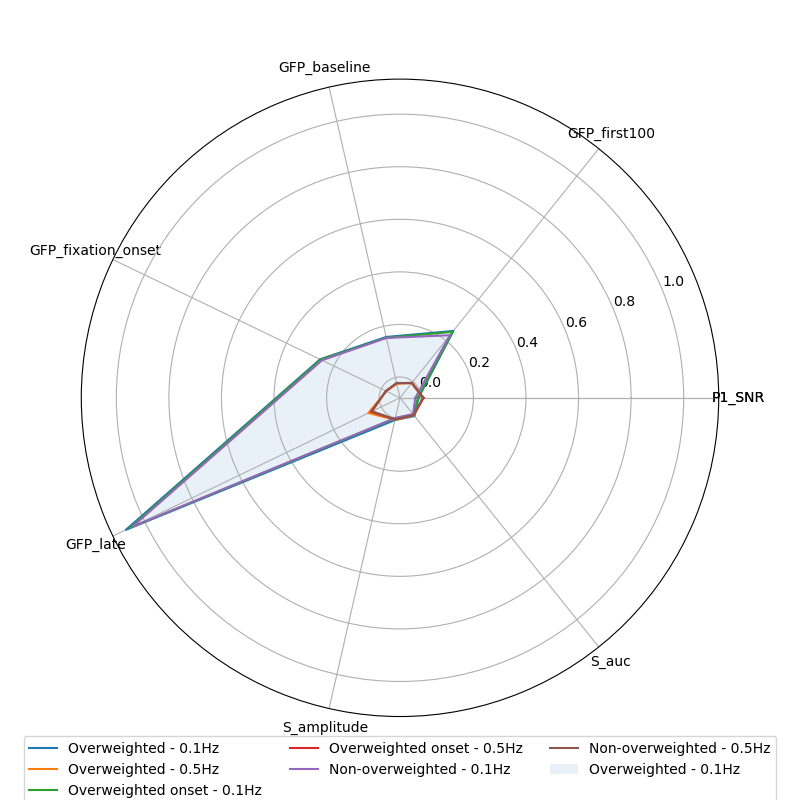

In [7]:
OVR_01Hz = norm_ovr[categories].loc[(slice(None), "0.1Hz"), :].mean(axis=0) 
OVR_05Hz = norm_ovr[categories].loc[(slice(None), "0.5Hz"), :].mean(axis=0) 
OVR_10Hz = norm_ovr[categories].loc[(slice(None), "1.0Hz"), :].mean(axis=0) 
OVR_20Hz = norm_ovr[categories].loc[(slice(None), "2.0Hz"), :].mean(axis=0) 

OVRons_01Hz = norm_ovrons[categories].loc[(slice(None), "0.1Hz"), :].mean(axis=0) 
OVRons_05Hz = norm_ovrons[categories].loc[(slice(None), "0.5Hz"), :].mean(axis=0) 
OVRons_10Hz = norm_ovrons[categories].loc[(slice(None), "1.0Hz"), :].mean(axis=0) 
OVRons_20Hz = norm_ovrons[categories].loc[(slice(None), "2.0Hz"), :].mean(axis=0) 

nOVR_01Hz = norm_novr[categories].loc[(slice(None), "0.1Hz"), :].mean(axis=0) 
nOVR_05Hz = norm_novr[categories].loc[(slice(None), "0.5Hz"), :].mean(axis=0) 
nOVR_10Hz = norm_novr[categories].loc[(slice(None), "1.0Hz"), :].mean(axis=0)
nOVR_20Hz = norm_novr[categories].loc[(slice(None), "2.0Hz"), :].mean(axis=0) 

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)    
ax.plot(label_loc, OVR_01Hz, label='Overweighted - 0.1Hz')
ax.plot(label_loc, OVR_05Hz, label='Overweighted - 0.5Hz')

ax.plot(label_loc, OVRons_01Hz, label='Overweighted onset - 0.1Hz')
ax.plot(label_loc, OVRons_05Hz, label='Overweighted onset - 0.5Hz')

ax.plot(label_loc, nOVR_01Hz, label='Non-overweighted - 0.1Hz')
ax.plot(label_loc, nOVR_05Hz, label='Non-overweighted - 0.5Hz')

ax.fill(label_loc, OVR_01Hz, label='Overweighted - 0.1Hz', alpha=0.1)
# plt.title('Average across participants', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
          ncol=3)
fig.tight_layout()

plt.show(fig)

In [8]:
df_ovr['Overweighting'] = 'OVER'
df_novr['Overweighting'] = 'NO_OVER'
df_ovrons['Overweighting'] = 'OVER_ONS'

all_ovr = pd.concat([df_ovr, df_novr, df_ovrons])

all_ovr.loc[:, all_ovr.columns!='Overweighting'].groupby(["type"]).agg(['mean', 'std'])


P1_SNR            P1_latency                GFP_n400                \
            mean        std       mean       std          mean           std   
type                                                                           
0.1Hz  18.859884  12.604187   0.103244  0.009165  9.960738e-07  4.519534e-07   
0.5Hz  19.140767  12.617203   0.102951  0.008962  6.847799e-07  2.450994e-07   
1.0Hz  19.402321  12.610674   0.103321  0.009238  5.559822e-07  1.888650e-07   
2.0Hz  18.706892  11.947808   0.103323  0.009097  4.873758e-07  1.909323e-07   

      S_amplitude           S_latency                   S_auc                \
             mean       std      mean       std          mean           std   
type                                                                          
0.1Hz    0.000004  0.000002  0.025914  0.008288  8.667755e-08  4.661813e-08   
0.5Hz    0.000004  0.000002  0.026010  0.008156  8.671892e-08  4.611620e-08   
1.0Hz    0.000004  0.000002  0.026020  0.008132  8.648912e-08  4.562432e-08   
2.0Hz    0.000004  0.000002  0.025960  0.008111  8.603562e-08  4.529604e-08   

       GFP_baseline                GFP_first100                \
               mean           std          mean           std   
type                                                            
0.1Hz  1.607829e-07  7.485753e-08  3.906041e-07  1.443773e-07   
0.5Hz  1.486167e-07  6.698068e-08  3.570270e-07  1.343487e-07   
1.0Hz  1.461806e-07  6.576610e-08  3.456676e-07  1.340972e-07   
2.0Hz  1.450245e-07  6.524801e-08  3.387330e-07  1.326773e-07   

      GFP_fixation_onset                    GFP_late                
                    mean           std          mean           std  
type                                                                
0.1Hz       2.981593e-07  1.336956e-07  5.563378e-07  3.189497e-07  
0.5Hz       2.669476e-07  1.133838e-07  2.937648e-07  1.763347e-07  
1.0Hz       2.551681e-07  1.021146e-07  1.609753e-07  1.076909e-07  
2.0Hz       2.567214e-07  9.883958e-08  1.171371e-07  7.893468e-08

In [9]:
all_ovr.groupby(["Overweighting"]).agg(['mean', 'std'])


P1_SNR            P1_latency                GFP_n400  \
                    mean        std       mean       std          mean   
Overweighting                                                            
NO_OVER        19.034639  12.452421   0.103300  0.009154  6.715479e-07   
OVER           19.247843  12.723309   0.103306  0.009053  6.915589e-07   
OVER_ONS       18.799915  12.107812   0.103024  0.009099  6.800520e-07   

                            S_amplitude           S_latency            \
                        std        mean       std      mean       std   
Overweighting                                                           
NO_OVER        3.467731e-07    0.000004  0.000002  0.025302  0.008629   
OVER           3.510086e-07    0.000004  0.000003  0.026957  0.007980   
OVER_ONS       3.510979e-07    0.000004  0.000002  0.025669  0.007750   

                      S_auc                GFP_baseline                \
                       mean           std          mean           std   
Overweighting                                                           
NO_OVER        8.387870e-08  4.181788e-08  1.504903e-07  6.907557e-08   
OVER           9.018312e-08  4.991432e-08  1.499476e-07  6.791375e-08   
OVER_ONS       8.537909e-08  4.520396e-08  1.500157e-07  6.852790e-08   

               GFP_first100               GFP_fixation_onset                \
                       mean           std               mean           std   
Overweighting                                                                
NO_OVER        3.579570e-07  1.390080e-07       2.701788e-07  1.138405e-07   
OVER           3.583401e-07  1.363356e-07       2.679722e-07  1.139946e-07   
OVER_ONS       3.577266e-07  1.377554e-07       2.695962e-07  1.141265e-07   

                   GFP_late                
                       mean           std  
Overweighting                              
NO_OVER        2.777232e-07  2.583911e-07  
OVER           2.871322e-07  2.589740e-07  
OVER_ONS       2.813059e-07  2.598049e-07

In [13]:
categories.append('Overweighting')

In [14]:
all_ovr[categories].groupby(['Overweighting', 'type']).agg(['mean','std'])


P1_SNR             GFP_first100                \
                          mean        std          mean           std   
Overweighting type                                                      
NO_OVER       0.1Hz  18.776285  12.968957  3.891374e-07  1.480844e-07   
              0.5Hz  19.137055  12.943121  3.568525e-07  1.372950e-07   
              1.0Hz  19.433905  12.670392  3.462935e-07  1.371039e-07   
              2.0Hz  18.791310  11.898686  3.395448e-07  1.358008e-07   
OVER          0.1Hz  19.136612  12.973024  3.917523e-07  1.442385e-07   
              0.5Hz  19.360561  12.936506  3.573272e-07  1.347988e-07   
              1.0Hz  19.623380  13.155471  3.456119e-07  1.345932e-07   
              2.0Hz  18.870821  12.536749  3.386690e-07  1.329399e-07   
OVER_ONS      0.1Hz  18.666754  12.336866  3.909227e-07  1.462888e-07   
              0.5Hz  18.924685  12.443911  3.569013e-07  1.360749e-07   
              1.0Hz  19.149677  12.473850  3.450974e-07  1.357049e-07   
              2.0Hz  18.458545  11.848330  3.379851e-07  1.343418e-07   

                     GFP_baseline               GFP_fixation_onset  \
                             mean           std               mean   
Overweighting type                                                   
NO_OVER       0.1Hz  1.611127e-07  7.641386e-08       2.985198e-07   
              0.5Hz  1.490367e-07  6.840622e-08       2.679537e-07   
              1.0Hz  1.464786e-07  6.720476e-08       2.563386e-07   
              2.0Hz  1.453333e-07  6.661548e-08       2.579031e-07   
OVER          0.1Hz  1.606461e-07  7.526149e-08       2.972837e-07   
              0.5Hz  1.483212e-07  6.722541e-08       2.655653e-07   
              1.0Hz  1.459939e-07  6.592532e-08       2.536957e-07   
              2.0Hz  1.448294e-07  6.547181e-08       2.553442e-07   
OVER_ONS      0.1Hz  1.605901e-07  7.575261e-08       2.986744e-07   
              0.5Hz  1.484922e-07  6.786300e-08       2.673237e-07   
              1.0Hz  1.460693e-07  6.667441e-08       2.554700e-07   
              2.0Hz  1.449110e-07  6.614423e-08       2.569169e-07   

                                       GFP_late               S_amplitude  \
                              std          mean           std        mean   
Overweighting type                                                          
NO_OVER       0.1Hz  1.359495e-07  5.479141e-07  3.271337e-07    0.000004   
              0.5Hz  1.146518e-07  2.876792e-07  1.787743e-07    0.000004   
              1.0Hz  1.029731e-07  1.584411e-07  1.087312e-07    0.000004   
              2.0Hz  9.954194e-08  1.168585e-07  8.003977e-08    0.000004   
OVER          0.1Hz  1.349606e-07  5.650635e-07  3.166200e-07    0.000004   
              0.5Hz  1.150390e-07  3.010816e-07  1.776349e-07    0.000004   
              1.0Hz  1.034792e-07  1.646396e-07  1.097381e-07    0.000004   
              2.0Hz  1.002331e-07  1.177440e-07  7.979749e-08    0.000004   
OVER_ONS      0.1Hz  1.352799e-07  5.560359e-07  3.249529e-07    0.000004   
              0.5Hz  1.147798e-07  2.925336e-07  1.790632e-07    0.000004   
              1.0Hz  1.037742e-07  1.598453e-07  1.086151e-07    0.000004   
              2.0Hz  1.005014e-07  1.168088e-07  7.997972e-08    0.000004   

                                      S_auc                   P1_SNR  \
                          std          mean           std       mean   
Overweighting type                                                     
NO_OVER       0.1Hz  0.000002  8.387511e-08  4.308864e-08  18.776285   
              0.5Hz  0.000002  8.407444e-08  4.256249e-08  19.137055   
              1.0Hz  0.000002  8.397691e-08  4.210891e-08  19.433905   
              2.0Hz  0.000002  8.358835e-08  4.189537e-08  18.791310   
OVER          0.1Hz  0.000003  9.066384e-08  5.138067e-08  19.136612   
              0.5Hz  0.000003  9.048963e-08  5.089241e-08  19.360561   
              1.0Hz  0.000003  9.006910e-08  5.034088e-08  19.623380   
 

In [40]:
ovr_metrics = dict()
ovrons_metrics = dict()
novr_metrics = dict()

for sbj_id in do_subjs:
    sbj_metrics_ovr = pd.DataFrame()
    sbj_path = path.join(config.data_path, config.map_subjects[sbj_id][0])
    
    for i in range(5):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_componentselection_{sbj_id}_{i+1}_overweight.csv")
                                  )
        sbj_metrics_ovr = pd.concat([sbj_metrics_ovr, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovr = sbj_metrics_ovr.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovr = sbj_metrics_ovr.groupby(["type"]).mean()
    
    ovr_metrics[sbj_id] = sbj_metrics_ovr

    sbj_metrics_ovrons = pd.DataFrame()
    
    for i in range(5):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_componentselection_{sbj_id}_{i+1}_overweight_onset.csv")
                                  )
        sbj_metrics_ovrons = pd.concat([sbj_metrics_ovrons, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovrons = sbj_metrics_ovrons.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovrons = sbj_metrics_ovrons.groupby(["type"]).mean()
    
    ovrons_metrics[sbj_id] = sbj_metrics_ovrons
    
    sbj_metrics_novr = pd.DataFrame()
    
    for i in range(5):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_componentselection_{sbj_id}_{i+1}_NOoverweight.csv")
                                  )
        sbj_metrics_novr = pd.concat([sbj_metrics_novr, blk_metrics], ignore_index=True)
    
    sbj_metrics_novr = sbj_metrics_novr.drop("Unnamed: 0", axis=1)
    sbj_metrics_novr = sbj_metrics_novr.groupby(["type"]).mean()
    novr_metrics[sbj_id] = sbj_metrics_novr

In [41]:
df_novr = pd.concat(novr_metrics.values(), keys=novr_metrics.keys())
df_ovr = pd.concat(ovr_metrics.values(), keys=ovr_metrics.keys())
df_ovrons = pd.concat(ovrons_metrics.values(), keys=ovrons_metrics.keys())

In [42]:
categories = [
              "P1_SNR",
              "GFP_first100",
              "GFP_baseline",
              "GFP_fixation_onset",
              "GFP_late",
              "S_amplitude",
              "S_auc",
             ]

# SNR does not need to be normalised as it has not unit, but other values 
# should be somehow scaled for comparison

norm_ovr = pd.DataFrame(columns=df_ovr.columns, index=df_ovr.index)
norm_ovrons = pd.DataFrame(columns=df_ovrons.columns, index=df_ovrons.index)
norm_novr = pd.DataFrame(columns=df_novr.columns, index=df_novr.index)

for category in norm_ovr.columns:
    scaler.fit(np.array(df_novr[category]).reshape(-1,1))
    norm_novr[category] = scaler.transform(np.array(df_novr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovr[category]).reshape(-1,1))
    norm_ovr[category] = scaler.transform(np.array(df_ovr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovrons[category]).reshape(-1,1))
    norm_ovrons[category] = scaler.transform(np.array(df_ovrons[category]).reshape(-1,1))

In [43]:
categories = [*categories, categories[0]]

In [44]:
def radar_plot(sbj_id, overweight, component_selection):
    plt.close('all')

    OVR_both = norm_ovr[categories].loc[sbj_id,"both"].values[:-1]
    OVR_eog = norm_ovr[categories].loc[sbj_id,"eog"].values[:-1]
    OVR_preICA = norm_ovr[categories].loc[sbj_id,"pre-ICA"].values[:-1]
    OVR_var = norm_ovr[categories].loc[sbj_id,"variance"].values[:-1]
    
    OVRons_both = norm_ovrons[categories].loc[sbj_id,"both"].values[:-1]
    OVRons_eog = norm_ovrons[categories].loc[sbj_id,"eog"].values[:-1]
    OVRons_preICA = norm_ovrons[categories].loc[sbj_id,"pre-ICA"].values[:-1]
    OVRons_var = norm_ovrons[categories].loc[sbj_id,"variance"].values[:-1]
       
    nOVR_both = norm_novr[categories].loc[sbj_id,"both"].values[:-1]
    nOVR_eog = norm_novr[categories].loc[sbj_id,"eog"].values[:-1]
#    nOVR_preICA = norm_novr[categories].loc[sbj_id,"pre-ICA"].values[:-1]
    nOVR_var = norm_novr[categories].loc[sbj_id,"variance"].values[:-1]
    
    
    OVR_both = [*OVR_both, OVR_both[0]]
    OVR_eog = [*OVR_eog, OVR_eog[0]]
    OVR_preICA = [*OVR_preICA, OVR_preICA[0]]
    OVR_var = [*OVR_var, OVR_var[0]]
 
    OVRons_both = [*OVRons_both, OVRons_both[0]]
    OVRons_eog = [*OVRons_eog, OVRons_eog[0]]
    OVRons_preICA = [*OVRons_preICA, OVRons_preICA[0]]
    OVRons_var = [*OVRons_var, OVRons_var[0]]
    
    nOVR_both = [*nOVR_both, nOVR_both[0]]
    nOVR_eog = [*nOVR_eog, nOVR_eog[0]]
#    nOVR_preICA = [*nOVR_preICA, nOVR_preICA[0]]
    nOVR_var = [*nOVR_var, nOVR_var[0]]
    
    ovr={'All': False,
         'no Overweighting': False, 
         'Overweighting': False, 
         'Onset Overweighting': False}
    
    comp={'All': False,
          'Both': False,
          'EOG': False,
          'Variance': False}

    ovr[overweight]=True
    comp[component_selection]=True
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    fig = plt.figure(figsize=(8.5,9))
    ax = plt.subplot(111, polar=True)
    if ovr['All'] | comp['All']:
        ax.plot(label_loc, OVR_both, label='Overweighted - Both')
        ax.plot(label_loc, OVR_eog, label='Overweighted - EOG')
        ax.plot(label_loc, OVR_var, label='Overweighted - Variance')
        ax.plot(label_loc, OVRons_both, label='Overweighted onset - Both') 
        ax.plot(label_loc, OVRons_eog, label='Overweighted onset - EOG')
        ax.plot(label_loc, OVRons_var, label='Overweighted onset - Variance')
        ax.plot(label_loc, nOVR_both, label='Non-overweighted - Both')
        ax.plot(label_loc, nOVR_eog, label='Non-overweighted - EOG')
        ax.plot(label_loc, nOVR_var, label='Non-overweighted - Variance')
    else:        
        if (ovr['Overweighting']) | (comp['Both']): 
            ax.plot(label_loc, OVR_both, label='Overweighted - Both', linewidth=3)
        if (ovr['Overweighting']) | (comp['EOG']): 
            ax.plot(label_loc, OVR_eog, label='Overweighted - EOG')
        # ax.plot(label_loc, OVR_preICA, label='Overweighted - preICA')
        if (ovr['Overweighting']) | (comp['Variance']): 
            ax.plot(label_loc, OVR_var, label='Overweighted - Variance')
        if (ovr['Onset Overweighting']) | (comp['Both']): 
            ax.plot(label_loc, OVRons_both, label='Overweighted onset - Both', linewidth=3) 
        if (ovr['Onset Overweighting']) | (comp['EOG']):
            ax.plot(label_loc, OVRons_eog, label='Overweighted onset - EOG')
        # ax.plot(label_loc, OVRons_preICA, label='Overweighted onset - preICA')
        if (ovr['Onset Overweighting']) | (comp['Variance']):
            ax.plot(label_loc, OVRons_var, label='Overweighted onset - Variance')
        if (ovr['no Overweighting']) | (comp['Both']):
            ax.plot(label_loc, nOVR_both, label='Non-overweighted - Both', linewidth=3)
        if (ovr['no Overweighting']) | (comp['EOG']):
            ax.plot(label_loc, nOVR_eog, label='Non-overweighted - EOG')
        if (ovr['no Overweighting']) | (comp['Variance']):
            ax.plot(label_loc, nOVR_var, label='Non-overweighted - Variance')
    #ax.fill(label_loc, OVR_both, label='Overweighted - Both', alpha=0.1)
    #plt.title(f'Participant {sbj_id}', size=20, y=1.05)
    
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
              ncol=3)
    fig.tight_layout()
    plt.show(fig)
  

In [45]:
widgets.interact(radar_plot, sbj_id=do_subjs,
                 overweight=['All','none','no Overweighting', 'Overweighting', 'Onset Overweighting'],
                 component_selection=['All','none', 'Both', 'EOG', 'Variance']);

interactive(children=(Dropdown(description='sbj_id', options=(1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

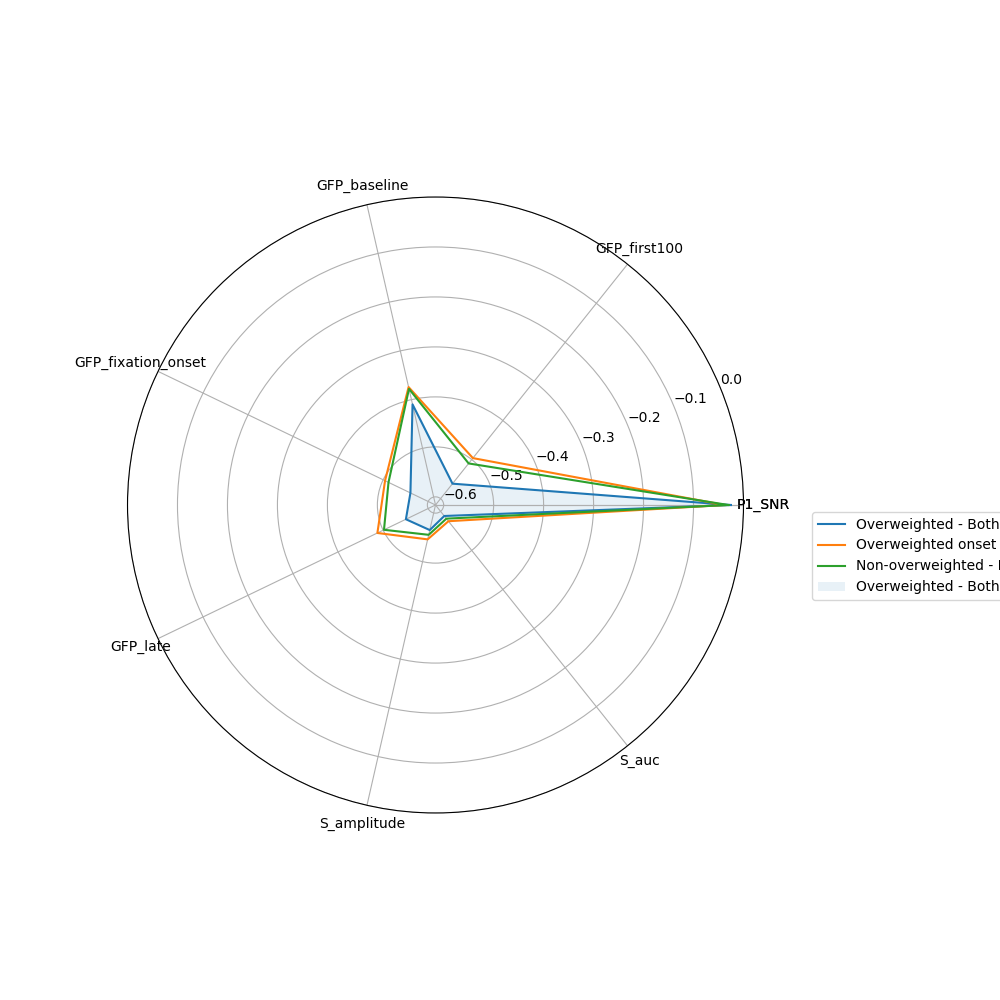

In [21]:
  

# average SNR

OVR_both = norm_ovr[categories].loc[(slice(None), "both"), :].mean(axis=0) 
OVR_eog = norm_ovr[categories].loc[(slice(None), "eog"), :].mean(axis=0) 
OVR_preICA = norm_ovr[categories].loc[(slice(None), "pre-ICA"), :].mean(axis=0) 
OVR_var = norm_ovr[categories].loc[(slice(None), "variance"), :].mean(axis=0) 

OVRons_both = norm_ovrons[categories].loc[(slice(None), "both"), :].mean(axis=0) 
OVRons_eog = norm_ovrons[categories].loc[(slice(None), "eog"), :].mean(axis=0) 
OVRons_preICA = norm_ovrons[categories].loc[(slice(None), "pre-ICA"), :].mean(axis=0) 
OVRons_var = norm_ovrons[categories].loc[(slice(None), "variance"), :].mean(axis=0) 

nOVR_both = norm_novr[categories].loc[(slice(None), "both"), :].mean(axis=0) 
nOVR_eog = norm_novr[categories].loc[(slice(None), "eog"), :].mean(axis=0) 
#    nOVR_preICA = norm_novr[categories].loc[(slice(None), "pre-ICA"), :].mean(axis=0)
nOVR_var = norm_novr[categories].loc[(slice(None), "variance"), :].mean(axis=0) 

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)    
ax.plot(label_loc, OVR_both, label='Overweighted - Both')
#ax.plot(label_loc, OVR_eog, label='Overweighted - EOG')
#ax.plot(label_loc, OVR_preICA, label='preICA')
#ax.plot(label_loc, OVRons_var, label='Overweighted onset - Variance')
ax.plot(label_loc, OVRons_both, label='Overweighted onset - Both')
#ax.plot(label_loc, OVRons_eog, label='Overweighted onset - EOG')
#ax.plot(label_loc, OVRons_var, label='Overweighted - Variance')
ax.plot(label_loc, nOVR_both, label='Non-overweighted - Both')
#ax.plot(label_loc, nOVR_eog, label='Non-overweighted - EOG')
#    plt.plot(label_loc, nOVR_preICA, label='Non-overweighted - preICA')
#ax.plot(label_loc, nOVR_var, label='Non-overweighted - Variance')
ax.fill(label_loc, OVR_both, label='Overweighted - Both', alpha=0.1);
#plt.title('Average across participants', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.1, 0.5), ncol=1)
leg = leg.set_in_layout(True)
plt.show()
    

In [22]:
df_ovr['Overweighting'] = 'OVER'
df_novr['Overweighting'] = 'NO_OVER'
df_ovrons['Overweighting'] = 'OVER_ONS'

all_ovr = pd.concat([df_ovr, df_novr, df_ovrons])

In [23]:
all_ovr.loc[:, all_ovr.columns!='Overweighting'].groupby(["type"]).agg(['mean', 'std'])

P1_SNR            P1_latency                GFP_n400  \
               mean        std       mean       std          mean   
type                                                                
both      18.859884  12.604187   0.103244  0.009165  9.960738e-07   
eog       18.699406  12.796309   0.103501  0.009210  1.043808e-06   
pre-ICA   20.029477  12.528696   0.103704  0.009213  3.644726e-06   
variance  19.428701  13.003224   0.103232  0.009081  1.369807e-06   

                       S_amplitude           S_latency            \
                   std        mean       std      mean       std   
type                                                               
both      4.519534e-07    0.000004  0.000002  0.025914  0.008288   
eog       4.885797e-07    0.000005  0.000003  0.025889  0.008349   
pre-ICA   1.560508e-06    0.000015  0.000006  0.032244  0.008981   
variance  8.164127e-07    0.000005  0.000003  0.027914  0.008545   

                 S_auc                GFP_baseline                \
                  mean           std          mean           std   
type                                                               
both      8.667755e-08  4.661813e-08  1.607829e-07  7.485753e-08   
eog       1.121891e-07  6.713043e-08  1.683967e-07  7.752864e-08   
pre-ICA   3.548065e-07  1.317061e-07  2.992483e-07  1.198096e-07   
variance  1.114094e-07  5.917234e-08  1.802472e-07  8.580404e-08   

          GFP_first100               GFP_fixation_onset                \
                  mean           std               mean           std   
type                                                                    
both      3.906041e-07  1.443773e-07       2.981593e-07  1.336956e-07   
eog       4.019875e-07  1.480060e-07       3.222564e-07  1.399114e-07   
pre-ICA   1.028824e-06  3.642108e-07       7.828596e-07  2.666780e-07   
variance  4.826697e-07  2.297716e-07       3.618589e-07  1.796512e-07   

              GFP_late                
                  mean           std  
type                                  
both      5.563378e-07  3.189497e-07  
eog       5.855560e-07  3.369090e-07  
pre-ICA   2.148910e-06  1.014907e-06  
variance  7.776537e-07  5.132869e-07

In [24]:
all_ovr.groupby(['Overweighting']).agg(['mean', 'std'])

P1_SNR            P1_latency            GFP_n400            \
                    mean        std       mean       std      mean       std   
Overweighting                                                                  
NO_OVER        19.162653  12.853185   0.103544  0.009098  0.000002  0.000001   
OVER           19.459431  12.777911   0.103357  0.009340  0.000002  0.000001   
OVER_ONS       19.141018  12.540623   0.103359  0.009023  0.000002  0.000001   

              S_amplitude           S_latency                   S_auc  \
                     mean       std      mean       std          mean   
Overweighting                                                           
NO_OVER          0.000007  0.000006  0.027328  0.009469  1.634556e-07   
OVER             0.000007  0.000006  0.029069  0.008566  1.713522e-07   
OVER_ONS         0.000007  0.000006  0.027574  0.008595  1.640041e-07   

                             GFP_baseline                GFP_first100  \
                        std          mean           std          mean   
Overweighting                                                           
NO_OVER        1.375160e-07  2.015897e-07  1.075945e-07  5.698383e-07   
OVER           1.378285e-07  2.043745e-07  1.072071e-07  5.919224e-07   
OVER_ONS       1.372280e-07  2.005420e-07  1.072413e-07  5.663036e-07   

                            GFP_fixation_onset                    GFP_late  \
                        std               mean           std          mean   
Overweighting                                                                
NO_OVER        3.560160e-07       4.379267e-07  2.735976e-07  9.992133e-07   
OVER           3.580235e-07       4.502370e-07  2.741045e-07  1.060580e-06   
OVER_ONS       3.550445e-07       4.356869e-07  2.729835e-07  9.915501e-07   

                             
                        std  
Overweighting                
NO_OVER        9.033351e-07  
OVER           9.042241e-07  
OVER_ONS       8.979538e-07

In [25]:
categories.append('Overweighting')

In [26]:
all_ovr[categories].groupby(['Overweighting', 'type']).agg(['mean','std'])


P1_SNR             GFP_first100                \
                             mean        std          mean           std   
Overweighting type                                                         
NO_OVER       both      18.776285  12.968957  3.891374e-07  1.480844e-07   
              eog       18.710069  13.131209  3.989965e-07  1.512353e-07   
              pre-ICA   20.029477  12.688304  1.028824e-06  3.688506e-07   
              variance  19.134780  13.308462  4.623949e-07  2.139750e-07   
OVER          both      19.136612  12.973024  3.917523e-07  1.442385e-07   
              eog       18.861208  13.041796  4.066163e-07  1.497698e-07   
              pre-ICA   20.029477  12.688304  1.028824e-06  3.688506e-07   
              variance  19.810427  13.100130  5.404966e-07  2.645511e-07   
OVER_ONS      both      18.666754  12.336866  3.909227e-07  1.462888e-07   
              eog       18.526942  12.698704  4.003497e-07  1.485428e-07   
              pre-ICA   20.029477  12.688304  1.028824e-06  3.688506e-07   
              variance  19.340897  13.087411  4.451175e-07  2.032477e-07   

                        GFP_baseline               GFP_fixation_onset  \
                                mean           std               mean   
Overweighting type                                                      
NO_OVER       both      1.611127e-07  7.641386e-08       2.985198e-07   
              eog       1.683278e-07  7.878858e-08       3.207845e-07   
              pre-ICA   2.992483e-07  1.213359e-07       7.828596e-07   
              variance  1.776702e-07  8.674384e-08       3.495429e-07   
OVER          both      1.606461e-07  7.526149e-08       2.972837e-07   
              eog       1.687188e-07  7.914242e-08       3.238455e-07   
              pre-ICA   2.992483e-07  1.213359e-07       7.828596e-07   
              variance  1.888850e-07  8.801742e-08       3.969592e-07   
OVER_ONS      both      1.605901e-07  7.575261e-08       2.986744e-07   
              eog       1.681435e-07  7.760855e-08       3.221392e-07   
              pre-ICA   2.992483e-07  1.213359e-07       7.828596e-07   
              variance  1.741862e-07  8.520122e-08       3.390746e-07   

                                          GFP_late               S_amplitude  \
                                 std          mean           std        mean   
Overweighting type                                                             
NO_OVER       both      1.359495e-07  5.479141e-07  3.271337e-07    0.000004   
              eog       1.409313e-07  5.747406e-07  3.433709e-07    0.000005   
              pre-ICA   2.700754e-07  2.148910e-06  1.027836e-06    0.000015   
              variance  1.751469e-07  7.252883e-07  4.771498e-07    0.000005   
OVER          both      1.349606e-07  5.650635e-07  3.166200e-07    0.000004   
              eog       1.460458e-07  6.017590e-07  3.431494e-07    0.000005   
              pre-ICA   2.700754e-07  2.148910e-06  1.027836e-06    0.000015   
              variance  1.949188e-07  9.265869e-07  6.067307e-07    0.000005   
OVER_ONS      both      1.352799e-07  5.560359e-07  3.249529e-07    0.000004   
              eog       1.379692e-07  5.801683e-07  3.364151e-07    0.000005   
              pre-ICA   2.700754e-07  2.148910e-06  1.027836e-06    0.000015   
              variance  1.692942e-07  6.810859e-07  4.234346e-07    0.000005   

                                         S_auc                   P1_SNR  \
                             std          mean           std       mean   
Overweighting type                                                        
NO_OVER       both      0.000002  8.387511e-08  4.308864e-08  18.776285   
              eog       0.000003  1.086331e-07  6.314222e-08  18.710069   
              pre-ICA   0.000006  3.548065e-07  1.333840e-07  20.029477   
              variance  0.000003  1.065076e-07  5.568406e-08  19.134780   
OVER          both      0.000003  9.066384e-08  5.138067e-08  19

In [74]:
df_ovr.loc[1]

P1_SNR  P1_latency      GFP_n400  S_amplitude  S_latency  \
type                                                                 
0.1Hz  33.208371      0.0966  8.803342e-07     0.000003     0.0232   
0.5Hz  29.173856      0.0978  7.748858e-07     0.000003     0.0232   
1.0Hz  28.287743      0.1004  8.495771e-07     0.000003     0.0232   
2.0Hz  27.179368      0.0992  8.336618e-07     0.000003     0.0232   

              S_auc  GFP_baseline  GFP_first100  GFP_fixation_onset  \
type                                                                  
0.1Hz  7.593884e-08  1.620907e-07  4.843548e-07        2.599991e-07   
0.5Hz  7.655375e-08  1.417399e-07  5.069614e-07        2.397035e-07   
1.0Hz  7.632530e-08  1.357683e-07  5.248509e-07        2.350136e-07   
2.0Hz  7.680633e-08  1.426118e-07  5.045678e-07        2.374291e-07   

           GFP_late  
type                 
0.1Hz  5.944474e-07  
0.5Hz  3.269898e-07  
1.0Hz  1.416758e-07  
2.0Hz  1.025616e-07

In [77]:
get_thebest=dict()

for sbj_id in do_subjs:
    get_thebest[sbj_id] = []
    for category in categories:
        miniminum = np.argmin([df_ovr[category].loc[sbj_id]['0.5Hz'],
                         df_novr[category].loc[sbj_id]['0.5Hz'],
                         df_ovrons[category].loc[sbj_id]['0.5Hz']])
        print(f"""Subject {sbj_id} - Measure {category} - best is {['Over', 
                                                                  'NoOver', 
                                                                  'OverOns'][miniminum]}""")
        if category!='P1_SNR':
            get_thebest[sbj_id].append(miniminum)
    print("\n\n")

Subject 1 - Measure P1_SNR - best is OverOns
Subject 1 - Measure GFP_first100 - best is OverOns
Subject 1 - Measure GFP_baseline - best is OverOns
Subject 1 - Measure GFP_fixation_onset - best is Over
Subject 1 - Measure GFP_late - best is OverOns
Subject 1 - Measure S_amplitude - best is Over
Subject 1 - Measure S_auc - best is Over
Subject 1 - Measure P1_SNR - best is OverOns



Subject 2 - Measure P1_SNR - best is OverOns
Subject 2 - Measure GFP_first100 - best is Over
Subject 2 - Measure GFP_baseline - best is NoOver
Subject 2 - Measure GFP_fixation_onset - best is Over
Subject 2 - Measure GFP_late - best is NoOver
Subject 2 - Measure S_amplitude - best is Over
Subject 2 - Measure S_auc - best is Over
Subject 2 - Measure P1_SNR - best is OverOns



Subject 3 - Measure P1_SNR - best is Over
Subject 3 - Measure GFP_first100 - best is Over
Subject 3 - Measure GFP_baseline - best is Over
Subject 3 - Measure GFP_fixation_onset - best is Over
Subject 3 - Measure GFP_late - best is NoOver

In [56]:
    np.argmin([df_ovr['P1_SNR'].loc[1]['both'],
             df_novr['P1_SNR'].loc[1]['both'],
         df_ovrons['P1_SNR'].loc[1]['both']])

2

In [179]:
categories_tomin = categories.copy()

In [180]:
del(categories_tomin[0])
del(categories_tomin[-1])


In [181]:
categories_tomin
categories_tomin = [*categories_tomin, categories_tomin[0]]

In [182]:
loc_min = np.linspace(start=0, stop=2 * np.pi, num=len(categories_tomin))

In [188]:
for sbj_id in do_subjs:
    print(f"\n {sbj_id}")
    for i, test in zip(['ovr','novr','ovrons'],
                       [norm_novr, norm_ovr, norm_ovrons]):
        x = np.cos(loc_min) * test[categories_tomin].loc[sbj_id].loc['0.5Hz']
        y = np.sin(loc_min) * test[categories_tomin].loc[sbj_id].loc['0.5Hz']
        print(i, shapely.geometry.MultiPoint(list(zip(x, y))).convex_hull.area)
    


 1
ovr 0.6963711217710773
novr 0.30310631494721985
ovrons 0.12878624828953344

 2
ovr 0.7699662165077924
novr 0.772962514494104
ovrons 0.5584218594840349

 3
ovr 0.26239941091603736
novr 0.7593169897193284
ovrons 0.15625784834025613

 5
ovr 1.2761525874389716
novr 1.218999254990802
ovrons 1.2548184345715667

 6
ovr 1.8135185070799753
novr 2.3971173941972124
ovrons 1.6515602601911925

 8
ovr 0.26499423932415267
novr 0.2701450155684758
ovrons 0.30281436147431473

 9
ovr 0.22890496101952365
novr 0.7200757141265397
ovrons 0.667651231764104

 10
ovr 2.253777193315091
novr 2.009557026471763
ovrons 1.9277930196515758

 11
ovr 4.124389690485122
novr 2.7559147882423902
ovrons 3.6875152180164115

 12
ovr 7.504426906964074
novr 5.701076038756385
ovrons 8.088216740018632

 13
ovr 0.4243938581018706
novr 0.7562183562599302
ovrons 0.5219859629184089

 14
ovr 1.4087372055034038
novr 1.9626413806556844
ovrons 1.4307918489214906

 15
ovr 0.4241227142493783
novr 0.1044063618633123
ovrons 0.397900848732

In [185]:
test[categories_tomin].loc[sbj_id].loc['0.5Hz']

GFP_first100          0.906230
GFP_baseline         -0.139974
GFP_fixation_onset   -0.158075
GFP_late              0.190881
S_amplitude           0.708487
S_auc                 0.912211
GFP_first100          0.906230
Name: 0.5Hz, dtype: float64

In [186]:
categories_tomin

['GFP_first100',
 'GFP_baseline',
 'GFP_fixation_onset',
 'GFP_late',
 'S_amplitude',
 'S_auc',
 'GFP_first100']

In [190]:
df_novr = norm_novr
df_ovr = norm_ovr
df_ovrons = norm_ovrons



In [ ]:
categories_tomin = [*categories_tomin, categories_tomin[0]]

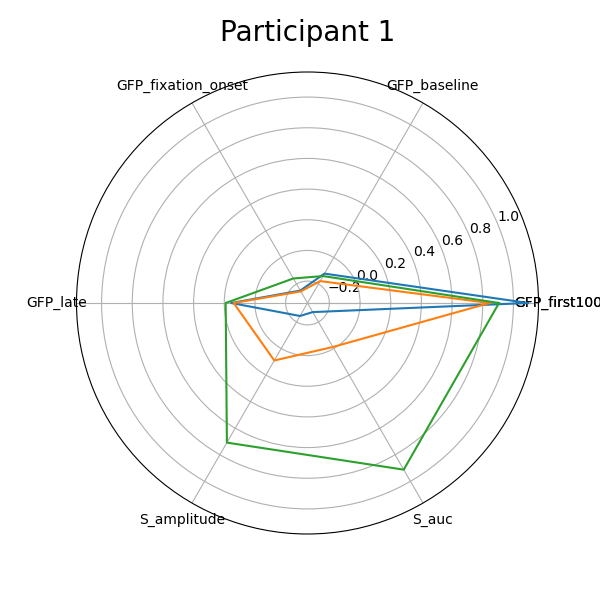

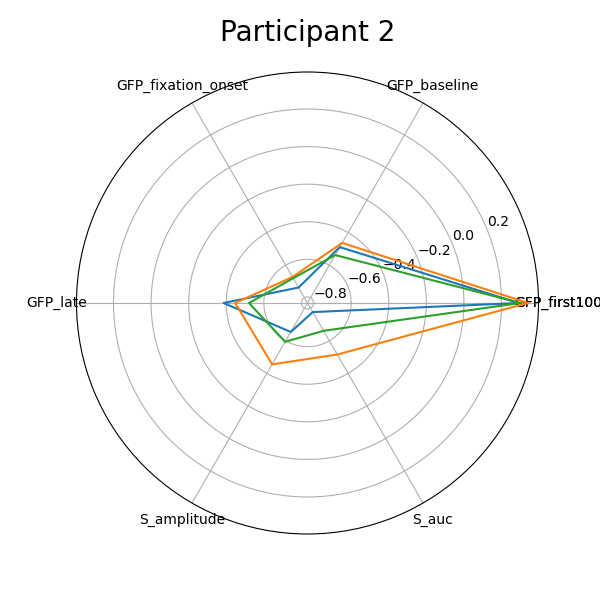

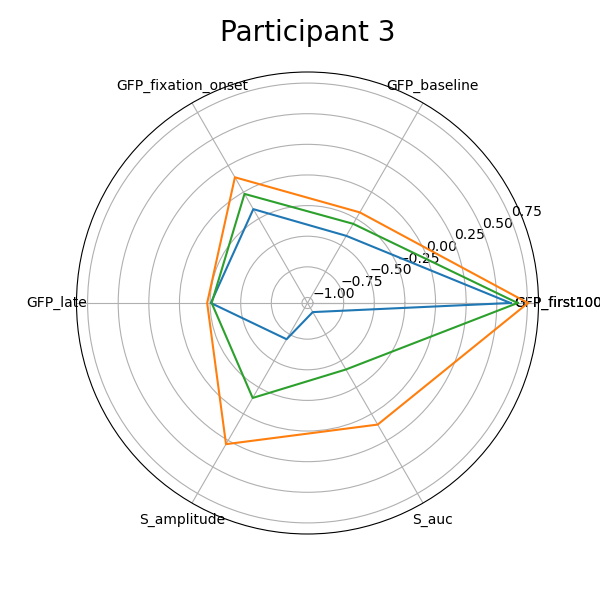

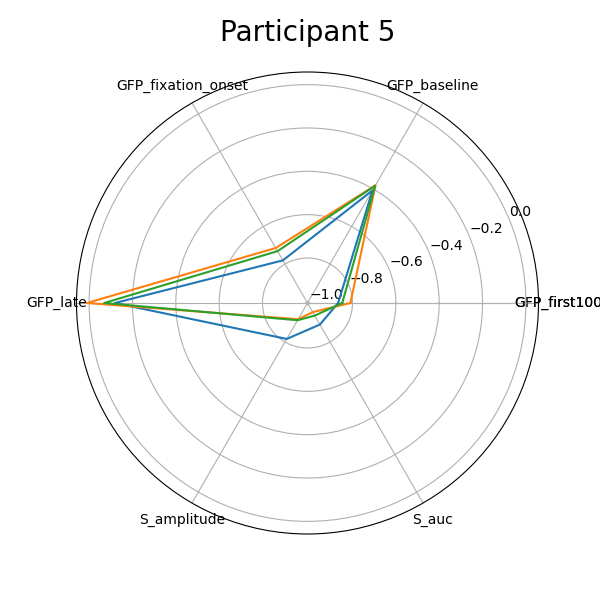

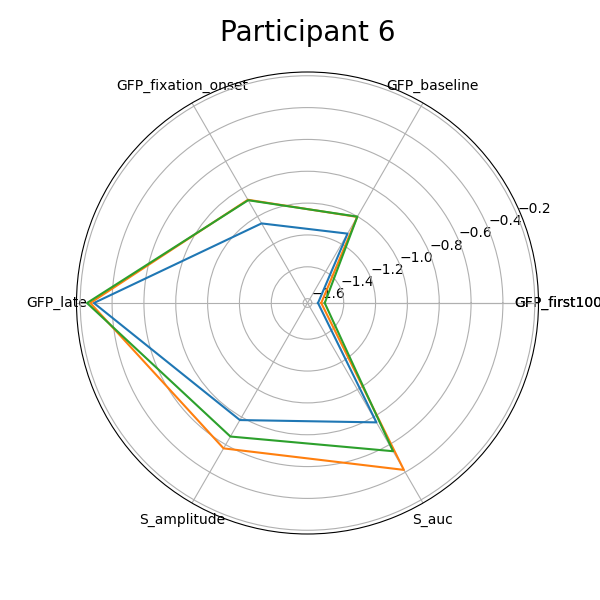

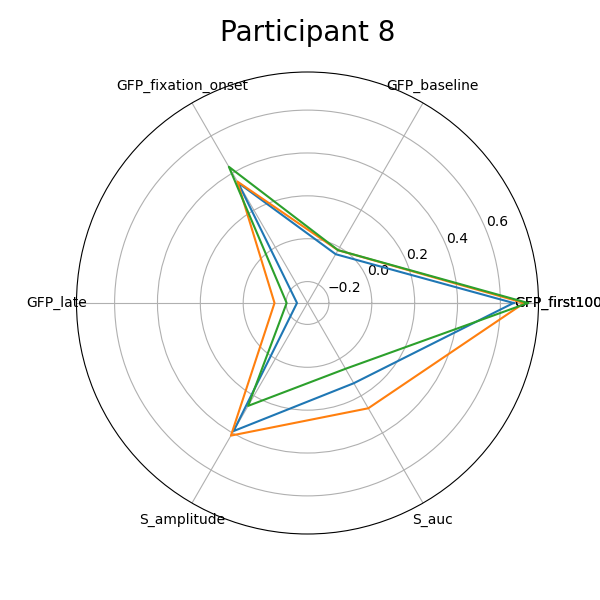

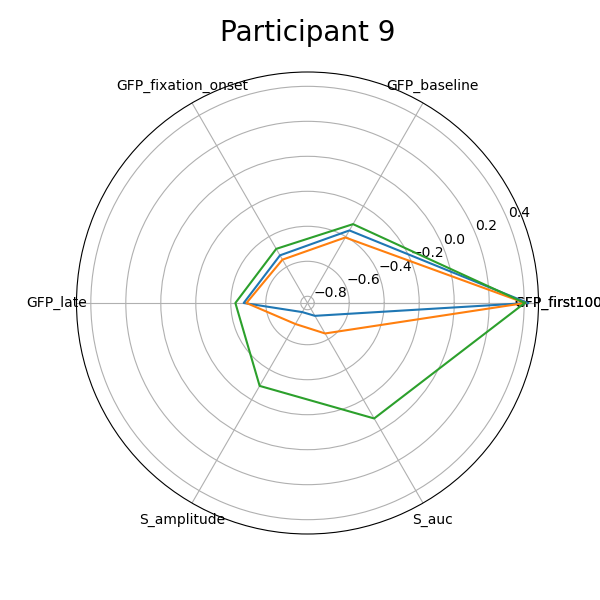

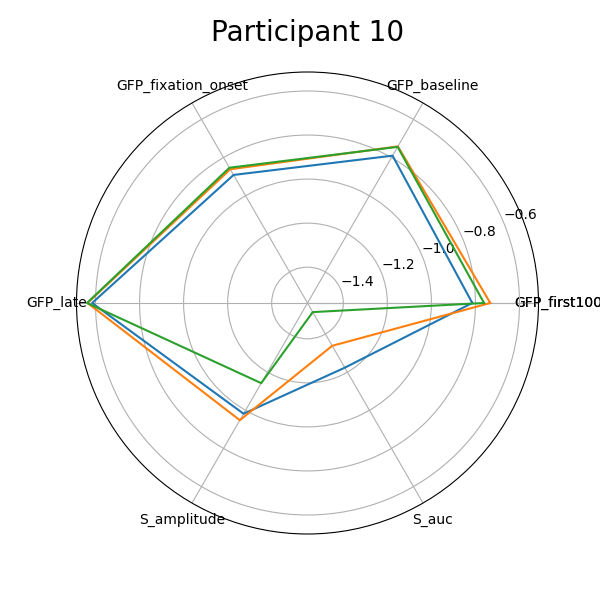

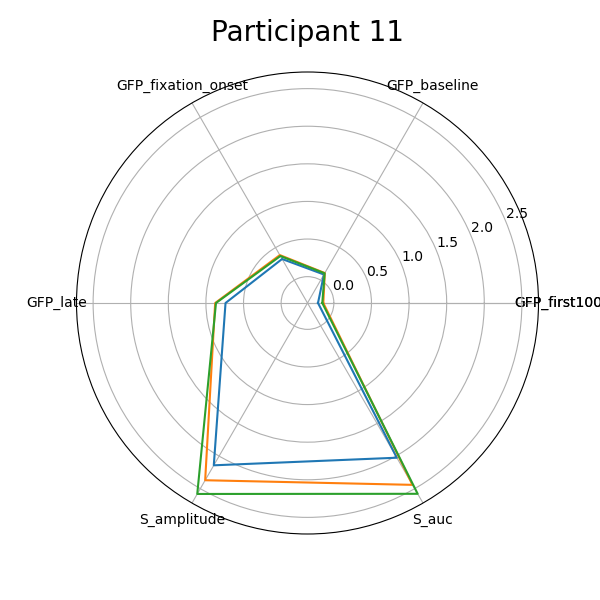

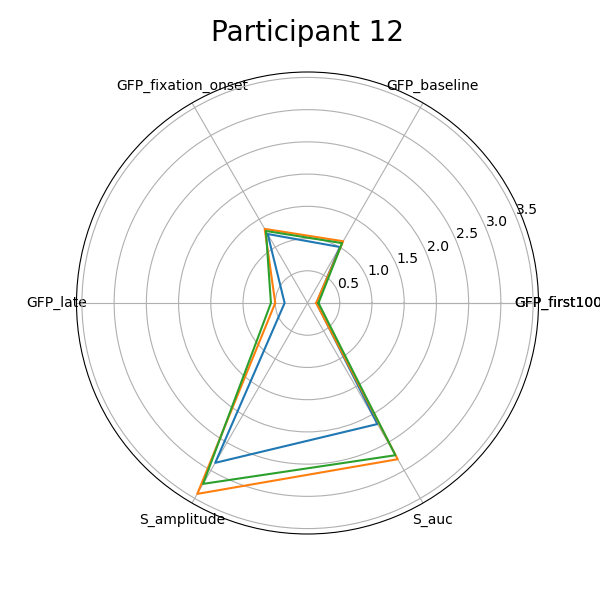

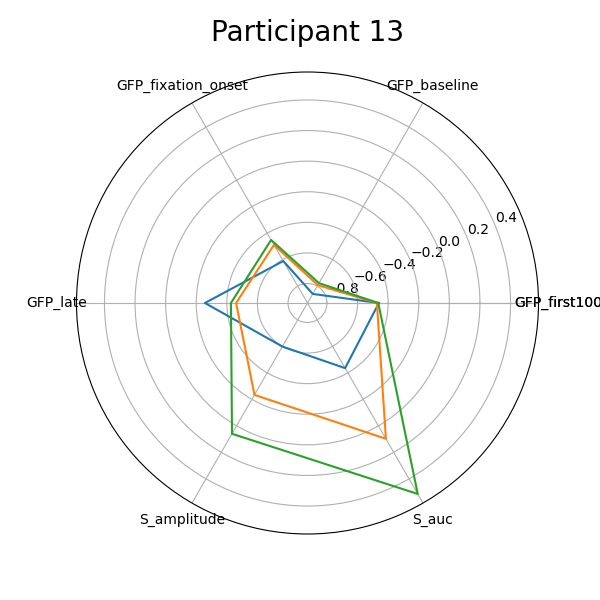

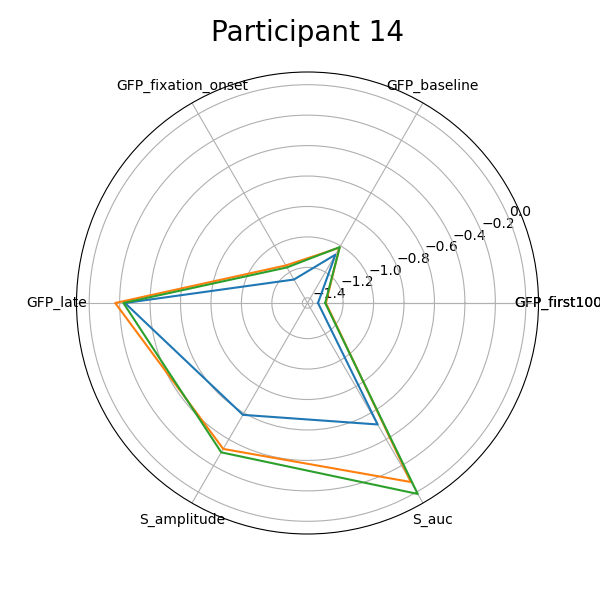

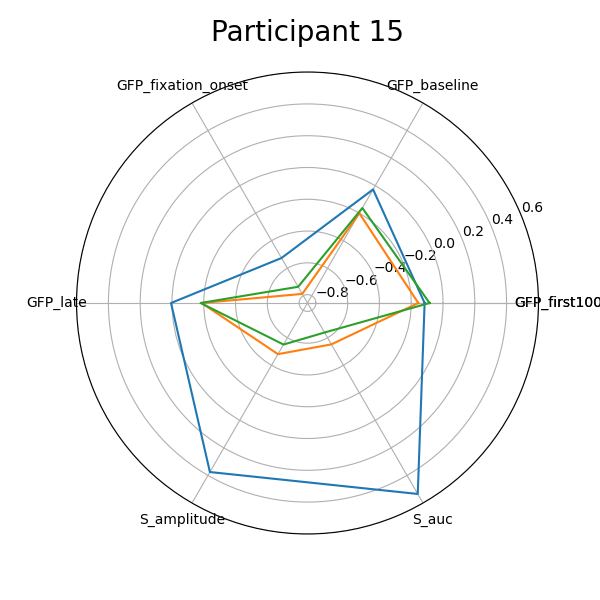

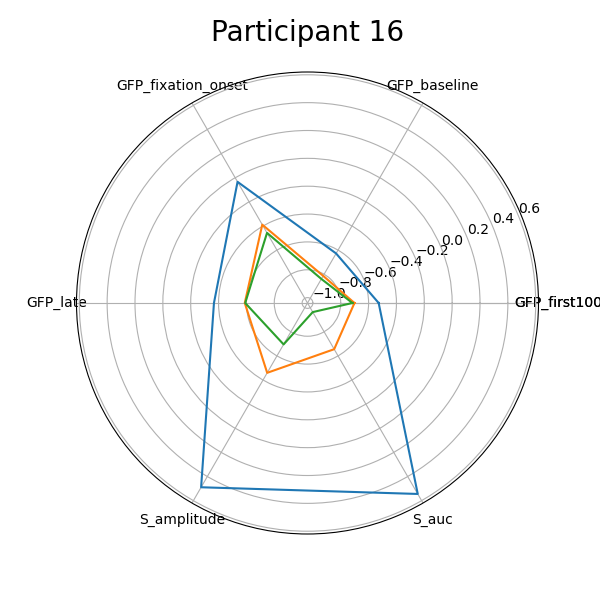

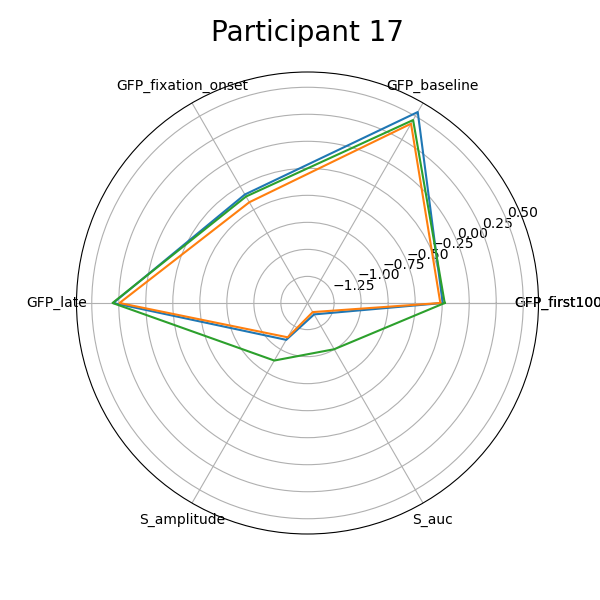

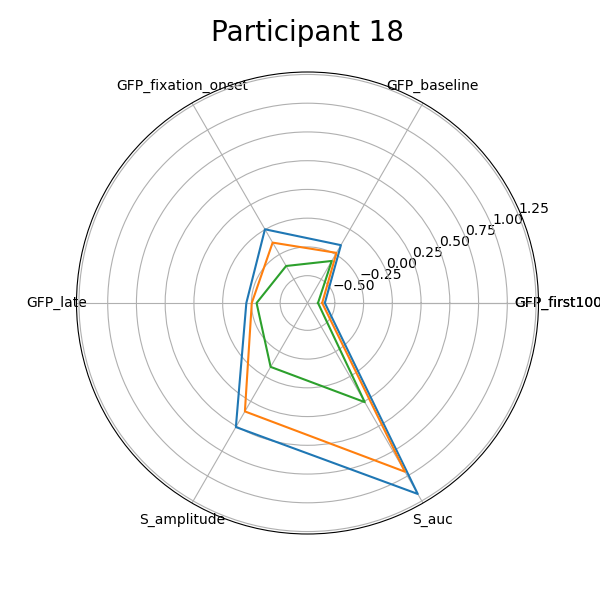

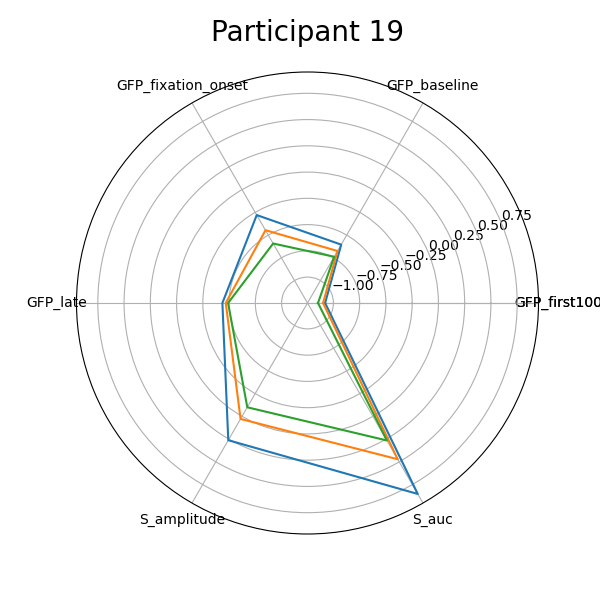

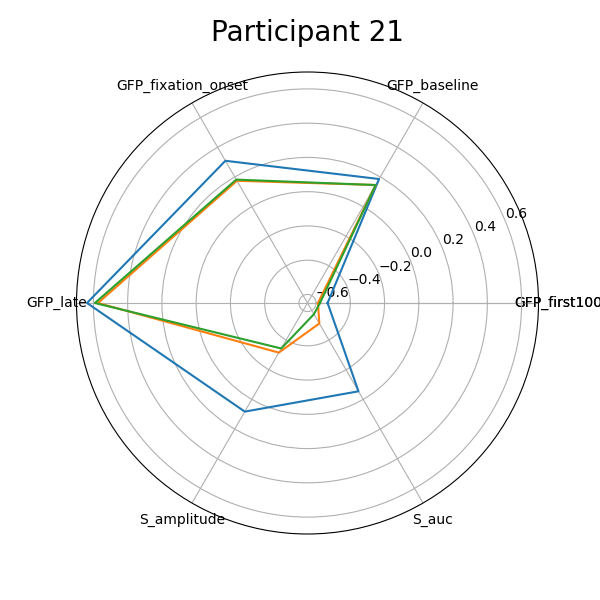

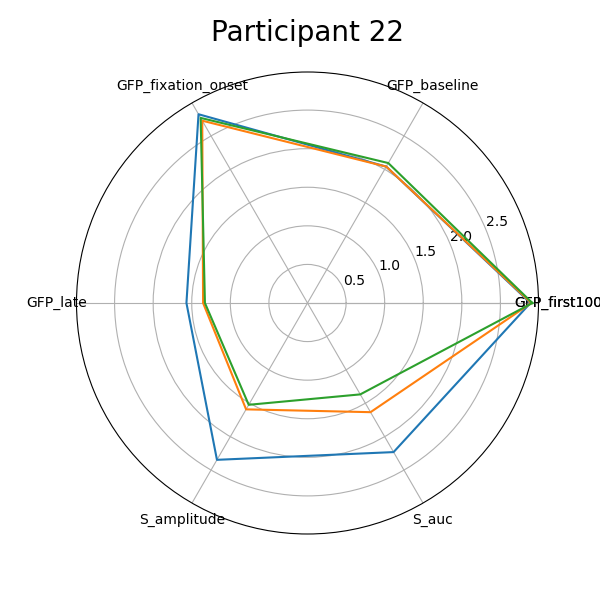

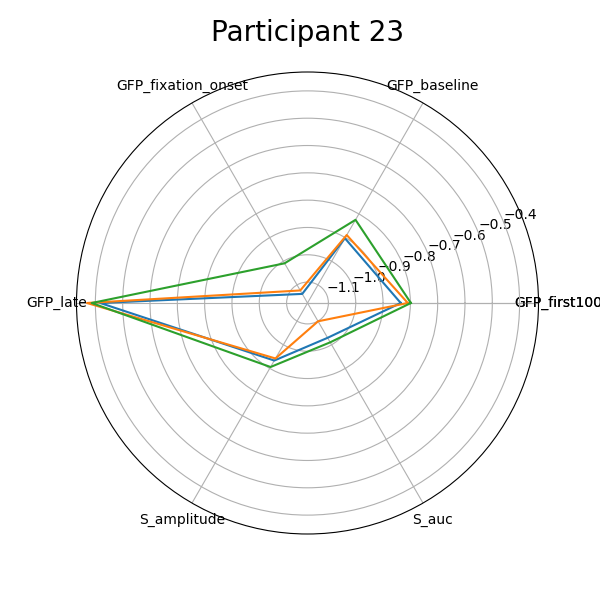

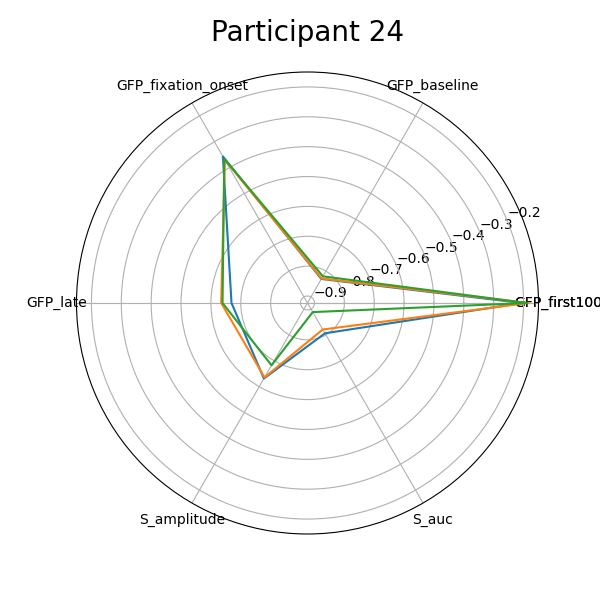

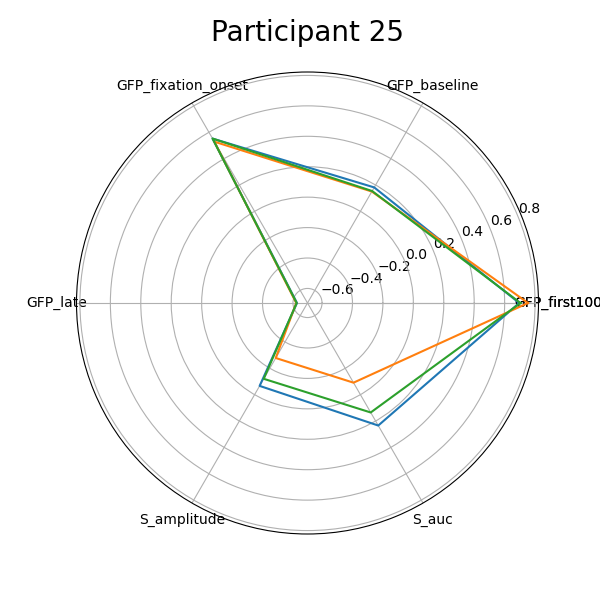

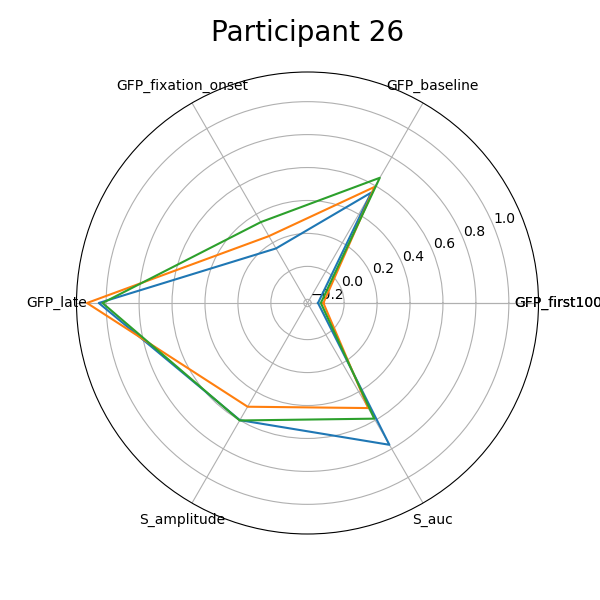

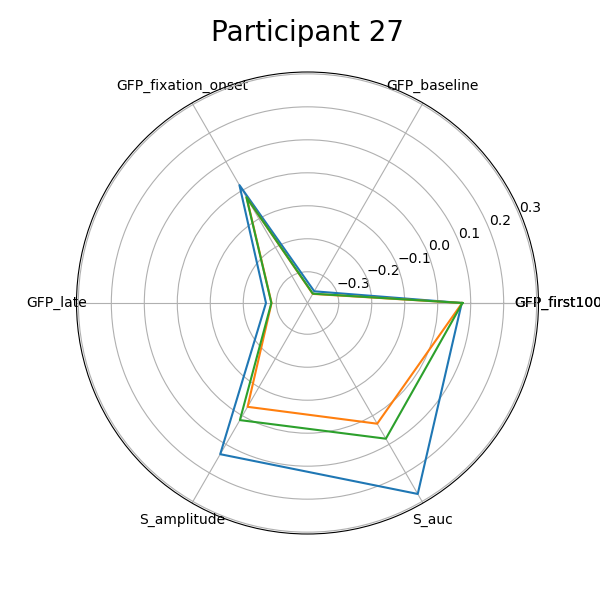

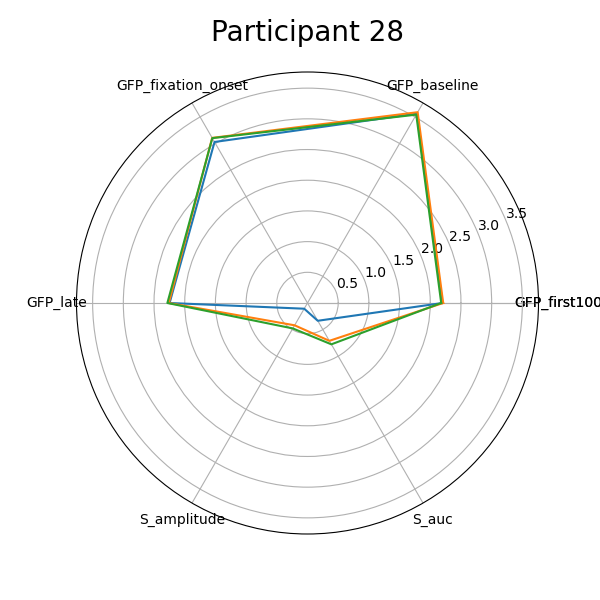

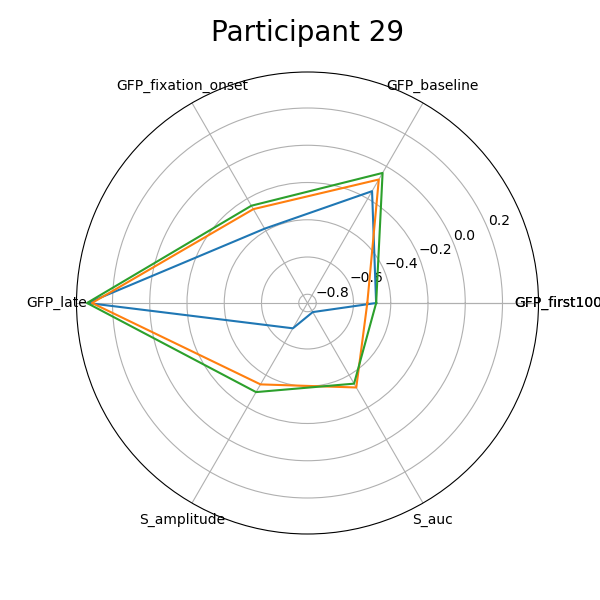

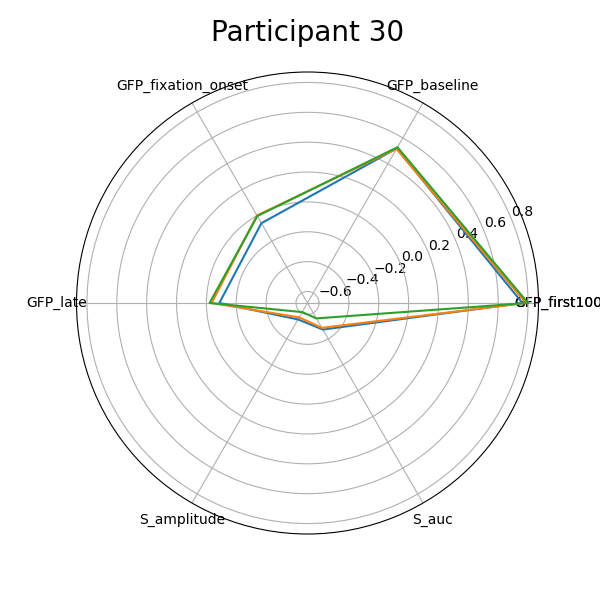

In [191]:
for sbj_id in do_subjs:
    OVR_01 = df_ovr[categories_tomin].loc[sbj_id,"0.1Hz"].values[:-1]
    OVR_05 = df_ovr[categories_tomin].loc[sbj_id,"0.5Hz"].values[:-1]
    OVR_10 = df_ovr[categories_tomin].loc[sbj_id,"1.0Hz"].values[:-1]
    OVR_20 = df_ovr[categories_tomin].loc[sbj_id,"2.0Hz"].values[:-1]

    OVR_01 = [*OVR_01, OVR_01[0]]
    OVR_05 = [*OVR_05, OVR_05[0]]
    OVR_10 = [*OVR_10, OVR_10[0]]
    OVR_20 = [*OVR_20, OVR_20[0]]
    
    nOVR_01 = df_novr[categories_tomin].loc[sbj_id,"0.1Hz"].values[:-1]
    nOVR_05 = df_novr[categories_tomin].loc[sbj_id,"0.5Hz"].values[:-1]
    nOVR_10 = df_novr[categories_tomin].loc[sbj_id,"1.0Hz"].values[:-1]
    nOVR_20 = df_novr[categories_tomin].loc[sbj_id,"2.0Hz"].values[:-1]

    nOVR_01 = [*nOVR_01, nOVR_01[0]]
    nOVR_05 = [*nOVR_05, nOVR_05[0]]
    nOVR_10 = [*nOVR_10, nOVR_10[0]]
    nOVR_20 = [*nOVR_20, nOVR_20[0]]
    
    OVRons_01 = df_ovrons[categories_tomin].loc[sbj_id,"0.1Hz"].values[:-1]
    OVRons_05 = df_ovrons[categories_tomin].loc[sbj_id,"0.5Hz"].values[:-1]
    OVRons_10 = df_ovrons[categories_tomin].loc[sbj_id,"1.0Hz"].values[:-1]
    OVRons_20 = df_ovrons[categories_tomin].loc[sbj_id,"2.0Hz"].values[:-1]

    OVRons_01 = [*OVRons_01, OVRons_01[0]]
    OVRons_05 = [*OVRons_05, OVRons_05[0]]
    OVRons_10 = [*OVRons_10, OVRons_10[0]]
    OVRons_20 = [*OVRons_20, OVRons_20[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories_tomin))
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)    
    #ax.plot(label_loc, OVR_01, label='Overweighted - 0.1 Hz')
    ax.plot(label_loc, OVR_05, label='Overweighted - 0.5 Hz')
    # ax.plot(label_loc, OVR_10, label='Overweighted - 1.0 Hz')
    # ax.plot(label_loc, OVR_20, label='Overweighted - 2.0 Hz')
    
    #ax.plot(label_loc, OVRons_01, label='Overweighted onset - 0.1 Hz')
    ax.plot(label_loc, OVRons_05, label='Overweighted onset - 0.5 Hz')
    # ax.plot(label_loc, OVRons_10, label='Overweighted onset - 1.0 Hz')
    # ax.plot(label_loc, OVRons_20, label='Overweighted onset - 2.0 Hz')
    
    #ax.plot(label_loc, nOVR_01, label='Non-overweighted - 0.1 Hz')
    ax.plot(label_loc, nOVR_05, label='Non-overweighted - 0.5 Hz')
    # ax.plot(label_loc, nOVR_10, label='Non-overweighted - 1.0 Hz')
    # ax.plot(label_loc, nOVR_20, label='Non-overweighted - 2.0 Hz')
    
    #ax.fill(label_loc, OVR_01, label='Overweighted - 0.1 Hz', alpha=0.1)
    plt.title(f'Participant {sbj_id}', size=20, y=1.05)

    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories_tomin)

In [147]:
categories_tomin

['GFP_first100',
 'GFP_baseline',
 'GFP_fixation_onset',
 'GFP_late',
 'S_amplitude',
 'S_auc',
 'GFP_first100']

In [156]:
loc_min 

array([0.        , 1.04719755, 2.0943951 , 3.14159265, 4.1887902 ,
       5.23598776, 6.28318531])

In [159]:
plt.close('all')

In [197]:
for i,j in zip(nOVR_05, loc_min):
    print(i,j)

0.7997991742007375 0.0
0.5278126102678234 1.0471975511965976
-0.0047701194285272265 2.0943951023931953
-0.02114059111034839 3.141592653589793
-0.6067682920546079 4.1887902047863905
-0.5580790821758267 5.235987755982988
0.7997991742007375 6.283185307179586
